# IA et Médecine Personnalisée - Partie 1

- Intervenant : Dr Michael Poette
- Mail : poette.m@chu-toulouse.fr

## Des Statistiques Conventionnelles à la Médecine Personnalisée

**UE IA en Santé - Module 5**

*Université de Toulouse - Faculté de Santé*

---

### Objectifs pédagogiques

À l'issue de ce module, vous serez capables de :

1. Comprendre la progression méthodologique des tests statistiques aux algorithmes d'apprentissage automatique
2. Identifier les avantages, limites et la complémentarité de chaque approche
3. Appliquer différentes méthodes sur des données réelles de santé (Framingham Heart Study)
4. Définir le concept de jumeau numérique et en définir les limites


In [10]:
# Configuration de l'environnement

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Dropdown, Checkbox, HTML
import ipywidgets as widgets
from IPython.display import display, clear_output
from tableone import TableOne

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report, log_loss, silhouette_score)
from sklearn.preprocessing import StandardScaler

# Statistiques
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import scipy.stats as stats

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Kaggle (avec fallback)
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    KAGGLE_AVAILABLE = True
except ImportError:
    KAGGLE_AVAILABLE = False

# Graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Seed pour reproductibilité
np.random.seed(42)

print("Environnement configuré avec succès")

Environnement configuré avec succès


---

# Introduction : Le Défi de la Médecine Personnalisée

## Contexte clinique

La médecine contemporaine fait face à un paradoxe fondamental :

Les **essais cliniques randomisés** nous indiquent qu'un traitement A est supérieur à un traitement B **en moyenne dans une population**. Cependant, devant un patient particulier, le clinicien doit décider : *"Pour CE patient précis, avec SON profil unique, quel est le meilleur choix ?"*  

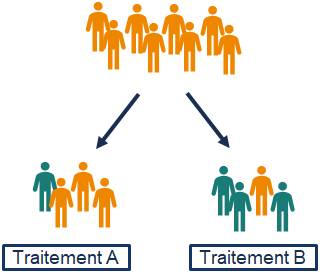  

### Le rôle de l'Evidence-Based Medicine (EBM)

L'EBM s'appuie sur trois piliers :
1. Les **meilleures preuves scientifiques** disponibles (essais cliniques, méta-analyses)
2. L'**expertise clinique** du praticien
3. Les **préférences du patient**

L'EBM fournit le cadre général issu des données populationnelles, que le clinicien adapte au cas individuel grâce à son expertise.

### Le rôle de l'intelligence artificielle

L'IA ne remplace pas l'EBM, elle la **complète** en :
- Calculant des scores de risque **individualisés** plutôt que populationnels
- Intégrant simultanément de **multiples variables** cliniques
- Détectant des **interactions complexes** entre facteurs de risque
- Quantifiant précisément le **bénéfice attendu** d'une intervention  

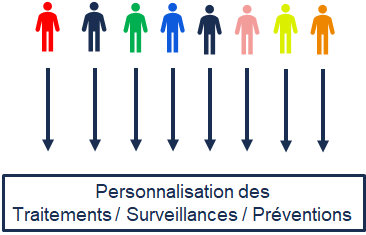  

### Comment passer d'une **conclusion populationnelle** à une **prédiction individuelle?**

---

## Jeu de Données : Framingham Heart Study

### Un peu de contexte

La **Framingham Heart Study** est l'une des études de cohorte les plus influentes de l'histoire de la cardiologie :

**Caractéristiques** :
- **Début** : 1948, Framingham (USA)
- **Population** : Plus de 4,000 participants suivis sur plusieurs décennies
- **Objectif** : Identifier les facteurs de risque cardiovasculaire
- **Contributions majeures** : 
  - Introduction du concept de "facteur de risque"
  - Démonstration du rôle du cholestérol, de l'hypertension, du tabagisme
  - Développement des premiers scores de risque cardiovasculaire

### Variables disponibles (16 au total)

**Démographiques** :
- `age` : Âge en années
- `male` : Sexe (1=Homme, 0=Femme)
- `education` : Niveau d'études (1 à 4)

**Comportementales** :
- `currentSmoker` : Fumeur actuel (1=Oui, 0=Non)
- `cigsPerDay` : Nombre de cigarettes par jour

**Cliniques** :
- `sysBP` : Pression artérielle systolique (mmHg)
- `diaBP` : Pression artérielle diastolique (mmHg)
- `heartRate` : Fréquence cardiaque (bpm)

**Biologiques** :
- `totChol` : Cholestérol total (mg/dL)
- `glucose` : Glycémie à jeun (mg/dL)

**Anthropométriques** :
- `BMI` : Indice de masse corporelle (kg/m²)

**Antécédents** :
- `prevalentStroke` : Antécédent d'AVC
- `prevalentHyp` : Hypertension artérielle
- `diabetes` : Diabète
- `BPMeds` : Traitement antihypertenseur

**Variable d'intérêt** :
- `TenYearCHD` : Survenue d'un événement coronarien dans les 10 ans (0=Non, 1=Oui)

### Objectif de notre analyse

Prédire le risque d'événement cardiovasculaire à 10 ans (`TenYearCHD`) à partir des caractéristiques du patient, en comparant différentes approches méthodologiques.

In [14]:
# Chargement du dataset Framingham

def load_framingham_data():
    """Charge le dataset Framingham depuis Kaggle ou crée des données simulées"""
    
    if KAGGLE_AVAILABLE:
        try:
            print("Tentative de téléchargement depuis Kaggle...")
            file_path = "framingham.csv"
            df = kagglehub.load_dataset(
                KaggleDatasetAdapter.PANDAS,
                "aasheesh200/framingham-heart-study-dataset",
                file_path
            )
            print("Dataset Framingham chargé depuis Kaggle")
            return df
        except Exception as e:
            print(f"Erreur Kaggle : {e}")
            print("Basculement vers données simulées...")
            return create_simulated_framingham()
    else:
        # Essayer de charger depuis fichier local
        try:
            df = pd.read_csv("framingham.csv")
            print("Dataset chargé depuis fichier local")
            return df
        except:
            print("Création de données simulées réalistes...")
            return create_simulated_framingham()

def create_simulated_framingham():
    """Crée des données simulées mimant les caractéristiques de Framingham"""
    n = 4240
    
    # Génération de données réalistes avec corrélations
    age = np.random.normal(50, 12, n).clip(30, 70).astype(int)
    male = np.random.binomial(1, 0.45, n)
    education = np.random.choice([1.0, 2.0, 3.0, 4.0], n, p=[0.2, 0.3, 0.3, 0.2])
    
    # Tabagisme
    currentSmoker = np.random.binomial(1, 0.35, n)
    cigsPerDay = currentSmoker * np.random.poisson(15, n).astype(float)
    
    # Variables physiologiques corrélées
    sysBP_base = 110 + (age - 50) * 0.5 + male * 5
    sysBP = sysBP_base + np.random.normal(0, 15, n)
    sysBP = sysBP.clip(90, 200)
    
    diaBP = sysBP * 0.65 + np.random.normal(0, 5, n)
    diaBP = diaBP.clip(60, 110)
    
    totChol = 200 + (age - 50) * 0.8 + np.random.normal(0, 40, n)
    totChol = totChol.clip(150, 400)
    
    BMI = 25 + np.random.normal(0, 4, n)
    BMI = BMI.clip(18, 40)
    
    heartRate = 75 + np.random.normal(0, 12, n)
    heartRate = heartRate.clip(50, 110)
    
    glucose = 85 + (age - 50) * 0.3 + np.random.normal(0, 20, n)
    glucose = glucose.clip(60, 200)
    
    # Antécédents
    prevalentHyp = (sysBP > 140).astype(int)
    diabetes = (glucose > 126).astype(int)
    BPMeds = prevalentHyp * np.random.binomial(1, 0.5, n)
    BPMeds = BPMeds.astype(float)
    prevalentStroke = np.random.binomial(1, 0.02, n)
    
    # Outcome : fonction réaliste des facteurs de risque
    risk_score = (
        (age - 50) * 0.05 +
        male * 0.3 +
        currentSmoker * 0.4 +
        (sysBP - 120) * 0.01 +
        (totChol - 200) * 0.002 +
        diabetes * 0.5 +
        prevalentHyp * 0.3 +
        (BMI - 25) * 0.05 +
        prevalentStroke * 0.8
    )
    
    prob = 1 / (1 + np.exp(-(risk_score - 1.5)))
    TenYearCHD = np.random.binomial(1, prob)
    
    df = pd.DataFrame({
        'male': male,
        'age': age,
        'education': education,
        'currentSmoker': currentSmoker,
        'cigsPerDay': cigsPerDay,
        'BPMeds': BPMeds,
        'prevalentStroke': prevalentStroke,
        'prevalentHyp': prevalentHyp,
        'diabetes': diabetes,
        'totChol': totChol,
        'sysBP': sysBP,
        'diaBP': diaBP,
        'BMI': BMI,
        'heartRate': heartRate,
        'glucose': glucose,
        'TenYearCHD': TenYearCHD
    })
    
    return df

# Chargement
df_framingham = load_framingham_data()

# Nettoyage
df_clean = df_framingham.dropna().reset_index(drop=True)

# Statistiques descriptives
print("Statistiques descriptives du dataset Framingham (sans valeurs manquantes) :")


cols = df_clean.columns.tolist()
categorial_cols = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
continuous = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
group_by = 'TenYearCHD'

mytable = TableOne(data=df_clean, columns=cols, categorical=categorial_cols, groupby=group_by, pval=False)

print(mytable.tabulate(tablefmt="github"))

Dataset chargé depuis fichier local
Statistiques descriptives du dataset Framingham (sans valeurs manquantes) :
|                        |     | Missing   | Overall      | 0            | 1            |
|------------------------|-----|-----------|--------------|--------------|--------------|
| n                      |     |           | 3658         | 3101         | 557          |
| male, n (%)            | 0   |           | 2035 (55.6)  | 1785 (57.6)  | 250 (44.9)   |
|                        | 1   |           | 1623 (44.4)  | 1316 (42.4)  | 307 (55.1)   |
| age, mean (SD)         |     | 0         | 49.6 (8.6)   | 48.7 (8.4)   | 54.3 (8.0)   |
| education, n (%)       | 1.0 |           | 1526 (41.7)  | 1235 (39.8)  | 291 (52.2)   |
|                        | 2.0 |           | 1101 (30.1)  | 970 (31.3)   | 131 (23.5)   |
|                        | 3.0 |           | 608 (16.6)   | 533 (17.2)   | 75 (13.5)    |
|                        | 4.0 |           | 423 (11.6)   | 363 (11.7)   | 60 

In [23]:
# Sélection d'un patient
# IMPORTANT : On sélectionne un patient qui a eu un événement CV pour rendre l'analyse plus pertinente

# Filtrer les patients avec événement cardiovasculaire
patients_avec_evenement = df_clean[df_clean['TenYearCHD'] == 1]

print(f"Nombre de patients avec événement CV : {len(patients_avec_evenement)}")
print(f"Proportion : {len(patients_avec_evenement)/len(df_clean)*100:.1f}%\n")

# Tirage aléatoire parmi les patients avec événement
patient_index_in_subset = np.random.randint(0, len(patients_avec_evenement))
patient_data = patients_avec_evenement.iloc[patient_index_in_subset].copy()

# Retrouver l'index dans le dataframe complet pour le retrait
patient_index_original = patients_avec_evenement.index[patient_index_in_subset]

# Retrait du dataset d'analyse pour éviter le data leakage
df_analysis = df_clean.drop(patient_index_original).reset_index(drop=True)

# Formatage adapté au sexe
is_male = patient_data['male'] == 1
sexe = "Homme" if is_male else "Femme"
nom_patient = "M. Dupont" if is_male else "Mme Martin"
article = "Ce patient" if is_male else "Cette patiente"
pronom_il = "Il" if is_male else "Elle"
pronom_le = "le" if is_male else "la"

# Mapping éducation
education_labels = {
    1.0: "Lycée non terminé",
    2.0: "Diplôme de lycée",
    3.0: "Études supérieures partielles",
    4.0: "Diplôme universitaire"
}
education_str = education_labels.get(patient_data['education'], "Non renseigné")

# Affichage du profil
print("="*70)
print(f"PATIENT")
print("="*70)

fumeur = "Oui" if patient_data['currentSmoker'] == 1 else "Non"
fumeur_label = "Fumeur actif" if is_male else "Fumeuse active"
hta = "Oui" if patient_data['prevalentHyp'] == 1 else "Non"
diabete = "Oui" if patient_data['diabetes'] == 1 else "Non"
traitement_hta = "Oui" if patient_data['BPMeds'] == 1 else "Non"
avc = "Oui" if patient_data['prevalentStroke'] == 1 else "Non"

print(f"  Sexe                      : {sexe}")
print(f"  Âge                       : {int(patient_data['age'])} ans")
print(f"  Niveau d'études           : {education_str}")
print(f"  IMC                       : {patient_data['BMI']:.1f} kg/m²")
print(f"  {fumeur_label:25s} : {fumeur}")
if patient_data['currentSmoker'] == 1:
    print(f"    Consommation            : {int(patient_data['cigsPerDay'])} cigarettes/jour")

print(f"\n  PA systolique             : {patient_data['sysBP']:.0f} mmHg")
print(f"  PA diastolique            : {patient_data['diaBP']:.0f} mmHg")
print(f"  Fréquence cardiaque       : {patient_data['heartRate']:.0f} bpm")

print(f"\n  Cholestérol total         : {patient_data['totChol']:.0f} mg/dL")
print(f"  Glycémie                  : {patient_data['glucose']:.0f} mg/dL")

print(f"\n  Hypertension artérielle   : {hta}")
print(f"  Traitement antihypertenseur: {traitement_hta}")
print(f"  Diabète                   : {diabete}")
print(f"  Antécédent d'AVC          : {avc}")

print("\n" + "="*70)
print(f"ÉVÉNEMENT CARDIOVASCULAIRE OBSERVÉ (10 ans) : OUI")
print("="*70)

# Sauvegarde pour usage ultérieur
patient_dict = {
    'data': patient_data.to_dict(),
    'nom': nom_patient,
    'sexe': sexe,
    'is_male': is_male,
    'article': article,
    'pronom_il': pronom_il,
    'pronom_le': pronom_le
}

Nombre de patients avec événement CV : 557
Proportion : 15.2%

PATIENT
  Sexe                      : Femme
  Âge                       : 66 ans
  Niveau d'études           : Lycée non terminé
  IMC                       : 29.8 kg/m²
  Fumeuse active            : Non

  PA systolique             : 175 mmHg
  PA diastolique            : 94 mmHg
  Fréquence cardiaque       : 95 bpm

  Cholestérol total         : 232 mg/dL
  Glycémie                  : 67 mg/dL

  Hypertension artérielle   : Oui
  Traitement antihypertenseur: Non
  Diabète                   : Non
  Antécédent d'AVC          : Non

ÉVÉNEMENT CARDIOVASCULAIRE OBSERVÉ (10 ans) : OUI


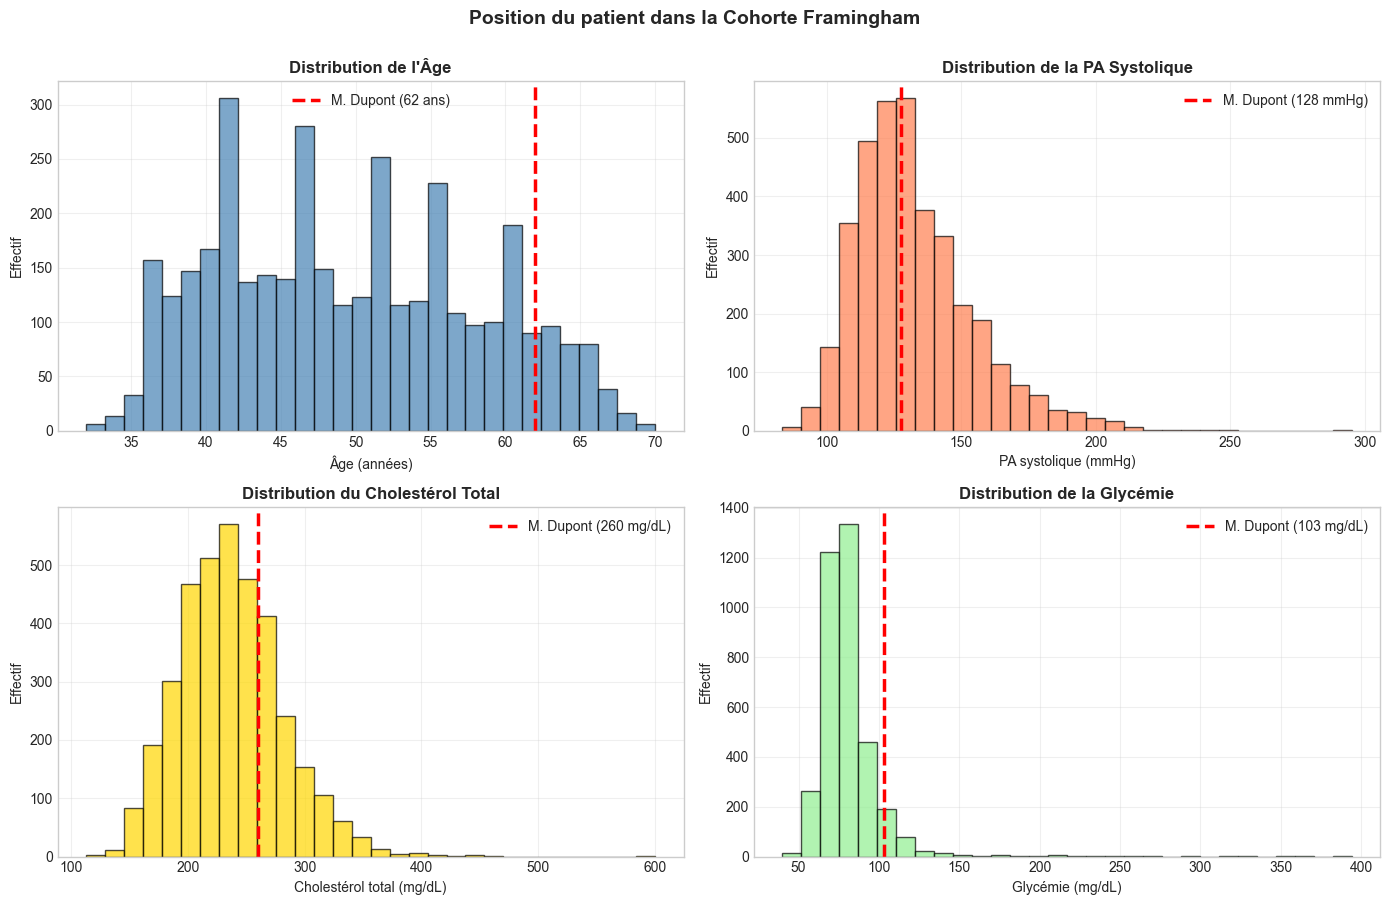

In [21]:
# Visualisation de la position du patient dans la population

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Graphique 1 : Distribution de l'âge
ax1 = axes[0, 0]
ax1.hist(df_analysis['age'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(patient_data['age'], color='red', linewidth=2.5, linestyle='--', 
            label=f'{nom_patient} ({int(patient_data["age"])} ans)')
ax1.set_xlabel('Âge (années)')
ax1.set_ylabel('Effectif')
ax1.set_title('Distribution de l\'Âge', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Graphique 2 : Distribution de la PA systolique
ax2 = axes[0, 1]
ax2.hist(df_analysis['sysBP'], bins=30, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(patient_data['sysBP'], color='red', linewidth=2.5, linestyle='--',
            label=f'{nom_patient} ({patient_data["sysBP"]:.0f} mmHg)')
ax2.set_xlabel('PA systolique (mmHg)')
ax2.set_ylabel('Effectif')
ax2.set_title('Distribution de la PA Systolique', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Graphique 3 : Distribution du cholestérol
ax3 = axes[1, 0]
ax3.hist(df_analysis['totChol'], bins=30, alpha=0.7, color='gold', edgecolor='black')
ax3.axvline(patient_data['totChol'], color='red', linewidth=2.5, linestyle='--',
            label=f'{nom_patient} ({patient_data["totChol"]:.0f} mg/dL)')
ax3.set_xlabel('Cholestérol total (mg/dL)')
ax3.set_ylabel('Effectif')
ax3.set_title('Distribution du Cholestérol Total', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Graphique 4 : Distribution du risque CV
ax4 = axes[1, 1]
ax4.hist(df_analysis['glucose'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.axvline(patient_data['glucose'], color='red', linewidth=2.5, linestyle='--',
            label=f'{nom_patient} ({patient_data["glucose"]:.0f} mg/dL)')
ax4.set_xlabel('Glycémie (mg/dL)')
ax4.set_ylabel('Effectif')
ax4.set_title('Distribution de la Glycémie', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.suptitle(f'Position du patient dans la Cohorte Framingham', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---

# Étape 1 : Tests Univariés (Chi², Student)

## Principe

Les tests statistiques classiques examinent **une variable à la fois** pour détecter une association avec l'outcome :

- **Test du Chi² (χ²)** : Pour variables catégorielles (ex: Fumeur vs Non-fumeur)
- **Test t de Student** : Pour variables continues (ex: PA systolique)

### Hypothèses testées

**H₀ (hypothèse nulle)** : Il n'existe pas d'association entre la variable et le risque cardiovasculaire

**H₁ (hypothèse alternative)** : Il existe une association significative (seuil α = 0.05)

### Interprétation

- **p-value < 0.05** : Association statistiquement significative (on rejette H₀)
- **Odds Ratio (OR)** : Quantifie la force de l'association pour variables catégorielles
  - OR = 1 : Pas d'effet
  - OR > 1 : Augmentation du risque
  - OR < 1 : Diminution du risque

## Objectif de cette étape

Identifier quelles variables sont significativement associées au risque cardiovasculaire, avant de les combiner dans des modèles plus sophistiqués.

In [ ]:
# Widget interactif : Analyse univariée

def analyse_univariee(variable='currentSmoker'):
    """Analyse l'association entre une variable et le risque CV"""
    
    # Variables catégorielles
    variables_categorielles = ['male', 'currentSmoker', 'diabetes', 
                               'prevalentHyp', 'BPMeds', 'prevalentStroke']
    
    is_categorical = variable in variables_categorielles
    
    # Créer la figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if is_categorical:
        # Test du Chi²
        contingency = pd.crosstab(df_analysis[variable], df_analysis['TenYearCHD'])
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        # Odds Ratio (si tableau 2x2)
        if contingency.shape == (2, 2):
            a, b = contingency.iloc[0, 0], contingency.iloc[0, 1]
            c, d = contingency.iloc[1, 0], contingency.iloc[1, 1]
            odds_ratio = (b * c) / (a * d) if (a * d) > 0 else np.nan
            
            # IC95% pour OR
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d) if min(a,b,c,d) > 0 else np.nan
            or_lower = np.exp(np.log(odds_ratio) - 1.96 * se_log_or) if not np.isnan(se_log_or) else np.nan
            or_upper = np.exp(np.log(odds_ratio) + 1.96 * se_log_or) if not np.isnan(se_log_or) else np.nan
        else:
            odds_ratio = np.nan
            or_lower, or_upper = np.nan, np.nan
        
        # Graphique 1 : Table de contingence
        ax1 = axes[0]
        contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100
        
        if contingency_pct.shape[0] == 2:
            x = np.arange(2)
            width = 0.35
            
            bars1 = ax1.bar(x - width/2, contingency_pct.iloc[0], width, 
                           label=f'{variable}=0', alpha=0.7, color='steelblue')
            bars2 = ax1.bar(x + width/2, contingency_pct.iloc[1], width, 
                           label=f'{variable}=1', alpha=0.7, color='coral')
            
            # Ligne pour patient témoin dans la légende
            patient_value = int(patient_data[variable])
            patient_label_val = "Oui" if patient_value == 1 else "Non"
            ax1.plot([], [], ' ', label=f'Patient témoin : {patient_label_val}')
            
            ax1.set_ylabel('Pourcentage (%)')
            ax1.set_title(f'Répartition du risque CV selon la variable "{variable}"')
            ax1.set_xticks(x)
            ax1.set_xticklabels(['Pas d\'événement', 'Événement CV'])
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)
            
            # Valeurs sur barres
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height,
                            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Graphique 2 : Statistiques
        ax2 = axes[1]
        ax2.axis('off')
        
        stats_text = f"""
TEST DU CHI² (χ²)

Variable testée : {variable}
─────────────────────────────────────

Table de contingence :
{contingency.to_string()}

─────────────────────────────────────

Statistiques :
  χ² = {chi2:.2f}
  ddl = {dof}
  p-value = {p_value:.4f}
"""
        
        if not np.isnan(odds_ratio):
            stats_text += f"\n  Odds Ratio = {odds_ratio:.2f}"
            if not np.isnan(or_lower):
                stats_text += f"\n  IC95% = [{or_lower:.2f} - {or_upper:.2f}]"
        
        stats_text += "\n\n─────────────────────────────────────\n\nInterprétation :\n"
        
        if p_value < 0.05:
            stats_text += "  Association SIGNIFICATIVE (p < 0.05)\n"
            if not np.isnan(odds_ratio) and odds_ratio > 1:
                stats_text += f"  Le risque est multiplié par {odds_ratio:.2f}"
            elif not np.isnan(odds_ratio) and odds_ratio < 1:
                stats_text += f"  Le risque est divisé par {1/odds_ratio:.2f}"
        else:
            stats_text += "  Pas d'association significative (p ≥ 0.05)"
        
        ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
                fontsize=9, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
    else:
        # Test t de Student
        group_0 = df_analysis[df_analysis['TenYearCHD'] == 0][variable].dropna()
        group_1 = df_analysis[df_analysis['TenYearCHD'] == 1][variable].dropna()
        
        t_stat, p_value = ttest_ind(group_1, group_0)
        
        # Graphique 1 : Distributions
        ax1 = axes[0]
        ax1.hist(group_0, bins=30, alpha=0.6, label='Pas d\'événement', 
                color='green', edgecolor='black', density=True)
        ax1.hist(group_1, bins=30, alpha=0.6, label='Événement CV', 
                color='red', edgecolor='black', density=True)
        ax1.axvline(patient_data[variable], color='blue', linewidth=2.5, 
                   linestyle='--', label=f'Patient témoin : {patient_data[variable]:.1f}')
        ax1.set_xlabel(variable)
        ax1.set_ylabel('Densité')
        ax1.set_title(f'Distribution de la variable "{variable}" selon le risque CV')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Graphique 2 : Statistiques
        ax2 = axes[1]
        ax2.axis('off')
        
        cohen_d = (group_1.mean() - group_0.mean()) / np.sqrt((group_1.std()**2 + group_0.std()**2) / 2)
        
        stats_text = f"""
TEST T DE STUDENT

Variable testée : {variable}
─────────────────────────────────────

Statistiques descriptives :
  Pas d'événement : μ = {group_0.mean():.2f} (σ = {group_0.std():.2f})
  Événement CV    : μ = {group_1.mean():.2f} (σ = {group_1.std():.2f})
  
  Différence      : {group_1.mean() - group_0.mean():.2f}

─────────────────────────────────────

Test t :
  t = {t_stat:.2f}
  p-value = {p_value:.4f}
  
  Cohen's d = {cohen_d:.2f}

─────────────────────────────────────

Interprétation :
"""
        
        if p_value < 0.05:
            stats_text += "  Différence SIGNIFICATIVE (p < 0.05)\n"
            if group_1.mean() > group_0.mean():
                stats_text += f"  {variable} plus élevé chez patients à risque"
            else:
                stats_text += f"  {variable} plus bas chez patients à risque"
            
            if abs(cohen_d) > 0.8:
                stats_text += "\n  Taille d'effet : FORTE"
            elif abs(cohen_d) > 0.5:
                stats_text += "\n  Taille d'effet : MODÉRÉE"
            else:
                stats_text += "\n  Taille d'effet : FAIBLE"
        else:
            stats_text += "  Pas de différence significative (p ≥ 0.05)"
        
        ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
                fontsize=9, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()

# Interface
print("="*70)
print("EXPLORATION INTERACTIVE : TESTS UNIVARIÉS")
print("="*70)
print("\nSélectionnez une variable pour tester son association avec le risque CV\n")

variables_disponibles = [
    'currentSmoker', 'age', 'sysBP', 'totChol', 'BMI', 'glucose',
    'male', 'diabetes', 'prevalentHyp', 'BPMeds', 'heartRate', 'diaBP'
]

interact(analyse_univariee,
         variable=Dropdown(options=variables_disponibles, 
                          value='currentSmoker',
                          description='Variable :',
                          style={'description_width': 'initial'}))


EXPLORATION INTERACTIVE : TESTS UNIVARIÉS

Sélectionnez une variable pour tester son association avec le risque CV



interactive(children=(Dropdown(description='Variable :', options=('currentSmoker', 'age', 'sysBP', 'totChol', …

<function __main__.analyse_univariee(variable='currentSmoker')>

## Limites de l'approche univariée

1. **Ignore les interactions** : L'effet du tabac peut différer selon la présence d'HTA
2. **Pas de prédiction individuelle** : On sait qu'il y a association, mais pas "combien" pour ce patient
3. **Multiplicité des tests** : Tester 10 variables augmente le risque d'erreur de type I
4. **Pas de modèle prédictif** : Impossible de calculer une probabilité de risque

---

# Étape 2 : Régression Logistique Classique - Odds Ratios

## Principe

La **régression logistique** est le modèle de référence en épidémiologie clinique. Elle permet de :

1. **Combiner plusieurs variables** simultanément dans un même modèle
2. **Quantifier l'effet propre** de chaque variable (effet ajusté sur les autres)
3. **Calculer une probabilité individuelle** de risque pour un patient donné

### Modèle mathématique

$$\ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k$$

Où :
- $p$ = probabilité d'événement cardiovasculaire
- $X_i$ = variables prédictives (âge, tabac, PA systolique, etc.)
- $\beta_i$ = coefficients estimés par maximum de vraisemblance
- $\text{Odds Ratio}_i = e^{\beta_i}$ = effet multiplicatif sur le risque

### Interprétation des Odds Ratios (OR)

- **OR = 1** : La variable n'a pas d'effet sur le risque
- **OR = 2** : La variable multiplie le risque par 2
- **OR = 0.5** : La variable divise le risque par 2

### Avantages

- **Interprétabilité maximale** : Chaque coefficient a un sens clinique direct
- **Coefficients ajustés** : Effet de chaque variable en tenant compte des autres
- **Inférence statistique** : Tests de significativité, intervalles de confiance
- **Acceptation clinique** : Méthode de référence, largement utilisée et comprise

### Limites

- **Linéarité** : Suppose un effet additif des variables sur l'échelle logit
- **Pas d'interactions automatiques** : Il faut les spécifier manuellement
- **Sélection de variables** : Risque de sur-ajustement si trop de variables
- **Performance** : Limitée si les relations sont fortement non-linéaires

## Objectif de cette étape

Construire un modèle multivariable en sélectionnant interactivement les variables, visualiser les Odds Ratios, et calculer le risque personnalisé pour notre patient témoin.

In [29]:
# Widget interactif : Régression Logistique avec sélection de variables

# Définir toutes les variables disponibles
feature_cols_all = ['age', 'male', 'sysBP', 'totChol', 'BMI', 'glucose', 
                    'currentSmoker', 'diabetes', 'BPMeds', 'prevalentHyp']

def regression_logistique_interactive(
    inclure_age=True,
    inclure_sexe=True,
    inclure_tabac=True,
    inclure_pa=True,
    inclure_cholesterol=True,
    inclure_bmi=False,
    inclure_glucose=False,
    inclure_diabetes=False,
    inclure_bpmeds=False,
    inclure_hta=False
):
    """Régression logistique avec sélection interactive des variables"""
    
    # Sélection des variables selon checkboxes
    variables_selectionnees = []
    if inclure_age: variables_selectionnees.append('age')
    if inclure_sexe: variables_selectionnees.append('male')
    if inclure_tabac: variables_selectionnees.append('currentSmoker')
    if inclure_pa: variables_selectionnees.append('sysBP')
    if inclure_cholesterol: variables_selectionnees.append('totChol')
    if inclure_bmi: variables_selectionnees.append('BMI')
    if inclure_glucose: variables_selectionnees.append('glucose')
    if inclure_diabetes: variables_selectionnees.append('diabetes')
    if inclure_bpmeds: variables_selectionnees.append('BPMeds')
    if inclure_hta: variables_selectionnees.append('prevalentHyp')
    
    if len(variables_selectionnees) == 0:
        print("Veuillez sélectionner au moins une variable")
        return
    
    # Préparation données
    X = df_analysis[variables_selectionnees]
    y = df_analysis['TenYearCHD']
    
    # Split train/test (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Entraînement du modèle
    model_lr = LogisticRegression(max_iter=1000, random_state=42)
    model_lr.fit(X_train, y_train)
    
    # Prédictions sur test
    y_pred_proba = model_lr.predict_proba(X_test)[:, 1]
    y_pred = model_lr.predict(X_test)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction pour patient témoin
    patient_features = patient_data[variables_selectionnees].values.reshape(1, -1)
    patient_risk_lr = model_lr.predict_proba(patient_features)[0, 1] * 100
    patient_pred_class = model_lr.predict(patient_features)[0]
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Forest plot des Odds Ratios
    ax1 = axes[0]
    
    coefficients = model_lr.coef_[0]
    odds_ratios = np.exp(coefficients)
    
    # Labels lisibles
    var_labels_dict = {
        'age': 'Âge (par an)',
        'male': 'Sexe masculin',
        'currentSmoker': 'Tabagisme actif',
        'sysBP': 'PA systolique (par mmHg)',
        'totChol': 'Cholestérol (par mg/dL)',
        'BMI': 'IMC (par kg/m²)',
        'glucose': 'Glycémie (par mg/dL)',
        'diabetes': 'Diabète',
        'BPMeds': 'Traitement anti-HTA',
        'prevalentHyp': 'Hypertension artérielle'
    }
    
    labels = [var_labels_dict.get(v, v) for v in variables_selectionnees]
    
    # Tri par OR décroissant
    sorted_indices = np.argsort(odds_ratios)[::-1]
    odds_ratios_sorted = odds_ratios[sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]
    coeffs_sorted = coefficients[sorted_indices]
    
    # Couleurs selon effet
    colors = ['red' if or_val > 1 else 'green' for or_val in odds_ratios_sorted]
    
    y_pos = np.arange(len(labels_sorted))
    bars = ax1.barh(y_pos, odds_ratios_sorted, color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(1, color='black', linestyle='--', linewidth=2, label='OR = 1 (pas d\'effet)')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels_sorted, fontsize=9)
    ax1.set_xlabel('Odds Ratio (OR)')
    ax1.set_title('Forest Plot - Odds Ratios Ajustés', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # Valeurs sur barres
    for i, (or_val, coef) in enumerate(zip(odds_ratios_sorted, coeffs_sorted)):
        ax1.text(or_val + 0.05, i, f'OR={or_val:.2f}', 
                va='center', fontsize=8, fontweight='bold')
    
    # Graphique 2 : Courbe ROC
    ax2 = axes[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'Régression Logistique (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard (AUC = 0.5)')
    ax2.set_xlabel('Taux de Faux Positifs (1 - Spécificité)')
    ax2.set_ylabel('Taux de Vrais Positifs (Sensibilité)')
    ax2.set_title('Courbe ROC', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    # Point optimal (Youden's index)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = _[optimal_idx]
    ax2.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
            label=f'Seuil optimal = {optimal_threshold:.2f}')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Résultats détaillés
    print("\n" + "="*70)
    print("RÉGRESSION LOGISTIQUE - RÉSULTATS")
    print("="*70)
    
    print(f"\nMODÈLE :")
    print(f"  Nombre de variables : {len(variables_selectionnees)}")
    print(f"  Variables incluses  :")
    for var in variables_selectionnees:
        print(f"    - {var}")
    
    print(f"\nPERFORMANCE (sur set de test, n={len(y_test)}) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    print(f"\nODDS RATIOS (effet de chaque variable, toutes choses égales par ailleurs) :")
    for var, or_val, coef in zip(variables_selectionnees, odds_ratios, coefficients):
        signif = "***" if abs(coef) > 0.5 else ("**" if abs(coef) > 0.2 else "*")
        if or_val > 1:
            interpretation = f"augmente le risque de {(or_val-1)*100:.0f}%"
        else:
            interpretation = f"diminue le risque de {(1-or_val)*100:.0f}%"
        print(f"  {var:20s}: OR = {or_val:.2f} {signif} → {interpretation}")
    
    print(f"\nPRÉDICTION :")
    print(f"  Risque cardiovasculaire prédit : {patient_risk_lr:.1f}%")
    print(f"  Événement réellement observé   : {'Oui' if patient_data['TenYearCHD'] == 1 else 'Non'}")
    
    # Évaluation de la prédiction
    prediction_correcte = (patient_pred_class == patient_data['TenYearCHD'])

    print("\nINTERPRÉTATION :")
    print(f"  La régression logistique fournit un score personnalisé de {patient_risk_lr:.1f}%")
    
    # Sauvegarde pour comparaison ultérieure
    global results_lr
    results_lr = {
        'method': 'Régression Logistique',
        'variables': variables_selectionnees,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_lr,
        'coefficients': dict(zip(variables_selectionnees, coefficients)),
        'odds_ratios': dict(zip(variables_selectionnees, odds_ratios))
    }

# Interface
print("="*70)
print("RÉGRESSION LOGISTIQUE INTERACTIVE")
print("="*70)
print("\nSélectionnez les variables à inclure dans le modèle multivariable")
print("Conseil : Commencez avec 3-5 variables pour éviter le sur-ajustement\n")

interact(regression_logistique_interactive,
         inclure_age=Checkbox(value=True, description='Âge'),
         inclure_sexe=Checkbox(value=True, description='Sexe'),
         inclure_tabac=Checkbox(value=True, description='Tabagisme'),
         inclure_pa=Checkbox(value=True, description='PA systolique'),
         inclure_cholesterol=Checkbox(value=True, description='Cholestérol'),
         inclure_bmi=Checkbox(value=False, description='IMC'),
         inclure_glucose=Checkbox(value=False, description='Glycémie'),
         inclure_diabetes=Checkbox(value=False, description='Diabète'),
         inclure_bpmeds=Checkbox(value=False, description='Traitement anti-HTA'),
         inclure_hta=Checkbox(value=False, description='Hypertension'));

RÉGRESSION LOGISTIQUE INTERACTIVE

Sélectionnez les variables à inclure dans le modèle multivariable
Conseil : Commencez avec 3-5 variables pour éviter le sur-ajustement



interactive(children=(Checkbox(value=True, description='Âge'), Checkbox(value=True, description='Sexe'), Check…

## De la Régression Logistique au Score Clinique (ex: Framingham)

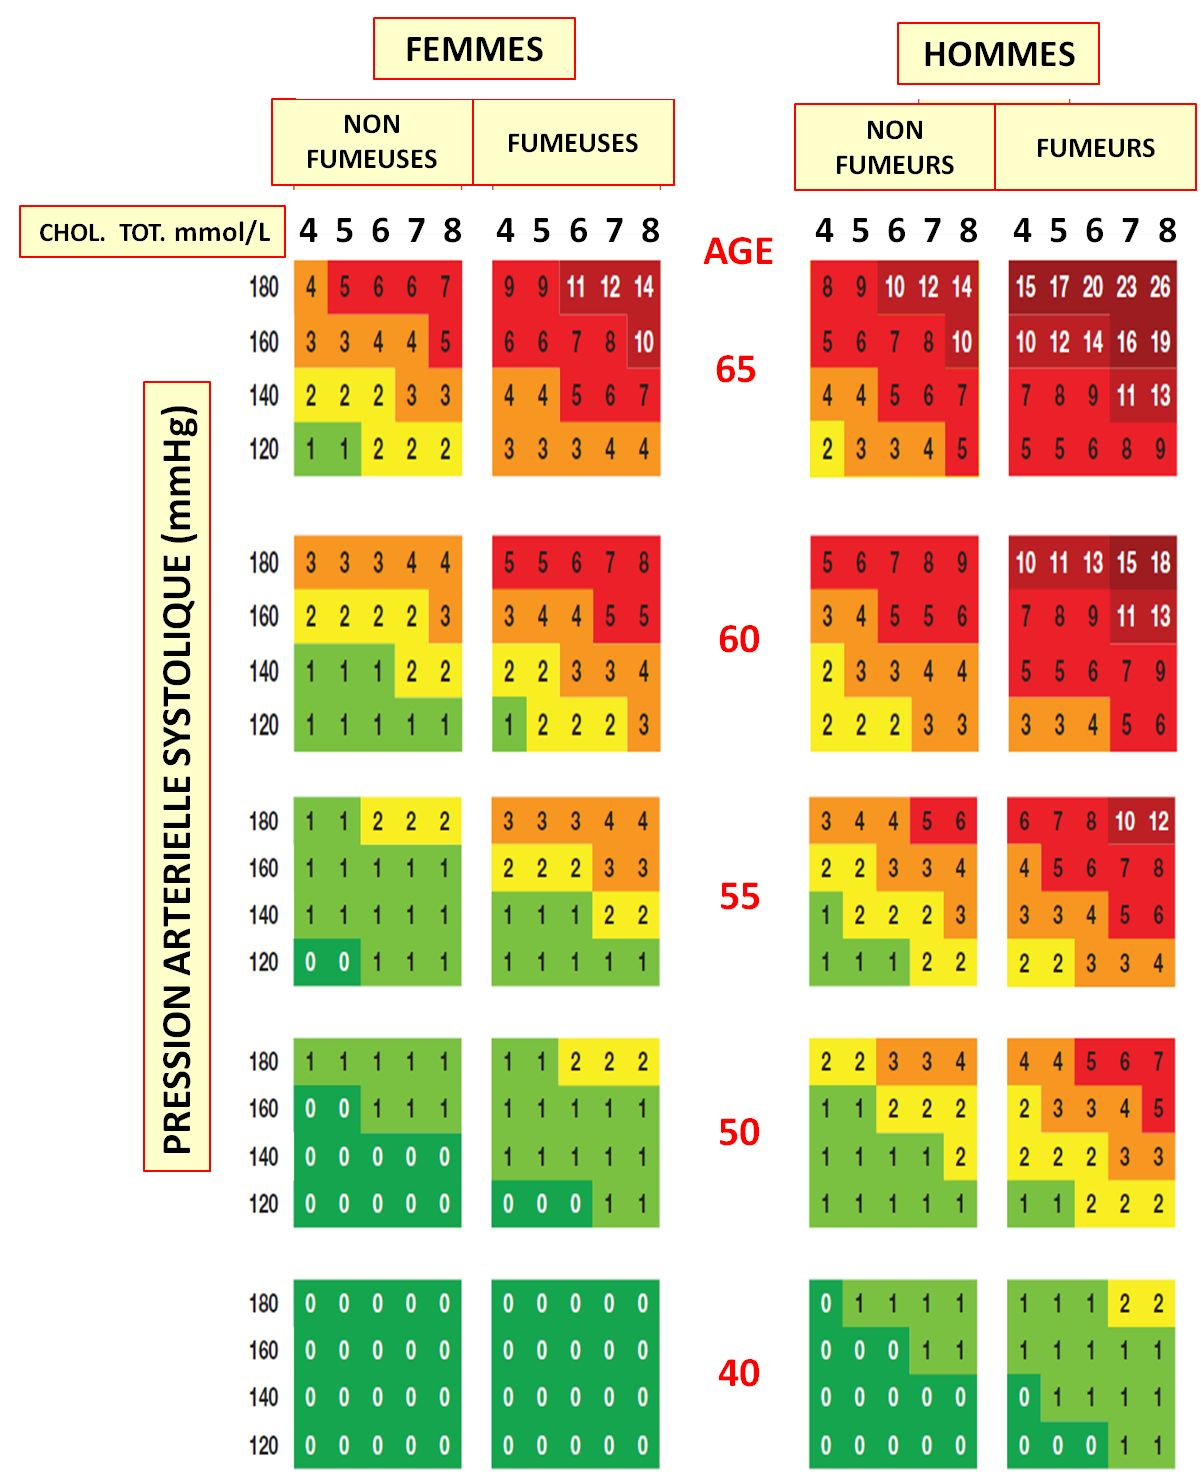

Pour passer d'une équation mathématique abstraite à un outil utilisable au lit du malade (comme le score de Framingham ou l'IGS II), il faut transformer le modèle statistique. Voici les étapes clés de cette "traduction" :

1.  **Le modèle mathématique (L'Odds Ratio) :**
    La régression logistique calcule une valeur basée sur une somme pondérée de variables. Chaque facteur de risque (ex: Tabac) est multiplié par un coefficient $\beta$.
    $$\text{Logit} = \beta_0 + \underbrace{\beta_1 \times \text{Age}}_{\text{Poids Age}} + \underbrace{\beta_2 \times \text{Tabac}}_{\text{Poids Tabac}} + \dots$$
    *En médecine, on parle souvent d'Odds Ratio ($OR = e^\beta$), qui nous dit combien de fois le risque est multiplié.*

2.  **La création des "Points" (Discrétisation) :**
    Il est impossible de calculer cette formule de tête lors d'une consultation. Pour créer un score papier :
    * On définit une unité de base (ex: le coefficient le plus petit).
    * On divise tous les coefficients par cette base et on **arrondit à l'entier**.
    > *Exemple :* Si le coefficient du Tabac est $0.8$ et l'unité de base est $0.2$, le tabac vaudra $0.8 / 0.2 = \textbf{4 points}$.

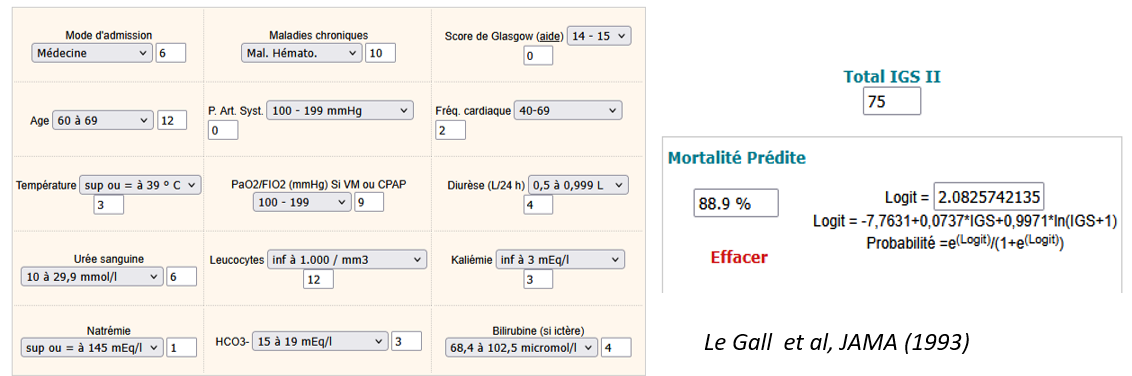

3.  **La Calibration (Du score au risque réel) :**
    **C'est l'étape critique souvent oubliée.**
    La sortie brute d'une régression logistique (ou la somme des points du score) n'est pas une probabilité parfaite dans la vraie vie.
    * Un modèle peut être très bon pour trier les patients (AUC élevé : il met bien les patients graves au-dessus des patients sains), mais être **mal calibré** (il prédit 80% de risque alors qu'en réalité, seuls 60% de ces patients mourront).
    * On construit donc une **Courbe de Calibration** (Predicted vs Observed) pour créer la table de conversion finale (l'abaque).

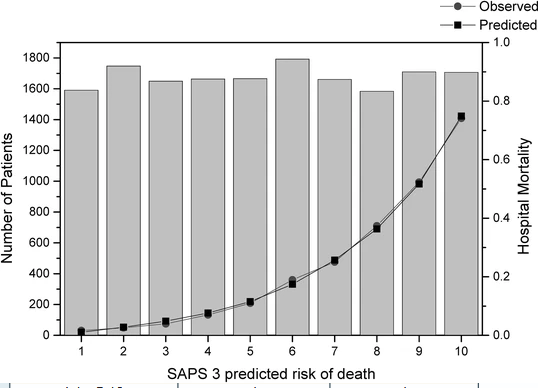

---

# Étape 3 : Régression Logistique Régularisée (Lasso/Ridge)

## Le problème du sur-apprentissage

Avec la régression logistique classique, inclure **trop de variables** conduit à :

1. **Sur-apprentissage** : Le modèle "mémorise" les particularités de l'échantillon d'entraînement
2. **Mauvaise généralisation** : Performance médiocre sur de nouvelles données
3. **Coefficients instables** : Grande variance des estimations
4. **Multicolinéarité** : Variables corrélées entre elles créent de l'instabilité

**Exemple** : Si on inclut à la fois PA systolique, PA diastolique, et HTA (qui sont fortement corrélées), les coefficients deviennent instables.

## Solution : La régularisation

Principe : Ajouter une **pénalité** à la fonction de perte pour limiter la taille des coefficients.

### Fonction de perte générale

$$\text{Perte totale} = \text{Log-Loss} + \lambda \times \text{Pénalité}$$

Où $\lambda$ (lambda) contrôle la force de la régularisation.

### Ridge (régularisation L2)

$$\min \left( \text{Log-Loss} + \lambda \sum_{i=1}^k \beta_i^2 \right)$$

**Effet** :
- Réduit tous les coefficients proportionnellement
- Aucun coefficient n'est exactement annulé (= 0)
- Toutes les variables restent dans le modèle
- Utile quand toutes les variables sont potentiellement pertinentes

### Lasso (régularisation L1)

$$\min \left( \text{Log-Loss} + \lambda \sum_{i=1}^k |\beta_i| \right)$$

**Effet** :
- Peut **annuler complètement** certains coefficients (= 0)
- **Sélection automatique** des variables importantes
- Modèle plus parcimonieux (moins de variables)
- Utile pour identifier les variables vraiment nécessaires

## Choix du paramètre λ (lambda)

- **λ = 0** : Pas de régularisation → Régression logistique classique
- **λ faible** : Peu de contrainte, coefficients proches du modèle classique
- **λ élevé** : Forte contrainte, coefficients fortement réduits (voire annulés)

Le λ optimal est déterminé par **validation croisée** : on teste différentes valeurs de λ et on garde celle qui donne la meilleure performance sur des données non vues.

## Avantages de la régularisation

1. **Prévient le sur-apprentissage** : Meilleure généralisation
2. **Stabilise les coefficients** : Moins de variance
3. **Gère la multicolinéarité** : Robuste aux variables corrélées
4. **Lasso : Sélection automatique** : Identifie les variables importantes
5. **Permet d'utiliser toutes les variables** : Pas besoin de sélection manuelle

## Limites

1. **Toujours linéaire** : Pas d'interactions automatiques
2. **Choix de λ** : Peut être sensible au jeu de données
3. **Lasso : Instabilité de sélection** : Variables sélectionnées peuvent varier
4. **Interprétabilité** : Coefficients plus difficiles à interpréter (effet de la pénalité)

## Objectif de cette étape

Explorer l'effet de la régularisation (Lasso vs Ridge) et de la force de pénalisation (λ) sur la sélection de variables et la performance du modèle.

In [ ]:
# Widget interactif : Régression Logistique Régularisée

def regression_regularisee(regularisation='Lasso', lambda_param=1.0):
    """
    Régression logistique régularisée (Lasso ou Ridge)
    
    Note : Dans sklearn, C = 1/lambda
    Plus C est petit, plus la régularisation est forte
    """
    
    # Utiliser toutes les variables disponibles
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Standardisation (essentielle pour la régularisation)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calcul de C (inverse de lambda)
    C_value = 1 / lambda_param
    
    # Modèle régularisé
    if regularisation == 'Lasso':
        model = LogisticRegression(
            penalty='l1', C=C_value, solver='liblinear', 
            max_iter=1000, random_state=42
        )
    else:  # Ridge
        model = LogisticRegression(
            penalty='l2', C=C_value, solver='lbfgs',
            max_iter=1000, random_state=42
        )
    
    model.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features_scaled = scaler.transform(
        patient_data[feature_cols_all].values.reshape(1, -1)
    )
    patient_risk = model.predict_proba(patient_features_scaled)[0, 1] * 100
    
    # Coefficients
    coefficients = model.coef_[0]
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Graphique 1 : Coefficients
    ax1 = axes[0]
    
    var_labels_dict = {
        'age': 'Âge', 'male': 'Sexe M', 'currentSmoker': 'Tabac',
        'sysBP': 'PA syst', 'totChol': 'Chol', 'BMI': 'IMC',
        'glucose': 'Glyc', 'diabetes': 'Diab', 'BPMeds': 'Trt HTA',
        'prevalentHyp': 'HTA'
    }
    
    labels = [var_labels_dict.get(v, v) for v in feature_cols_all]
    
    # Identifier variables sélectionnées (coef non nul)
    threshold = 1e-5
    selected = np.abs(coefficients) > threshold
    colors = ['green' if sel else 'lightgray' for sel in selected]
    
    y_pos = np.arange(len(labels))
    bars = ax1.barh(y_pos, coefficients, color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(0, color='black', linestyle='-', linewidth=1)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels, fontsize=9)
    ax1.set_xlabel('Coefficient (standardisé)')
    ax1.set_title(f'{regularisation} - Coefficients\n(λ = {lambda_param:.2f})', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Annotation des valeurs non nulles
    for i, (coef, sel) in enumerate(zip(coefficients, selected)):
        if sel:
            ax1.text(coef + 0.02 if coef > 0 else coef - 0.02, i,
                    f'{coef:.3f}', va='center', fontsize=7,
                    ha='left' if coef > 0 else 'right')
    
    # Graphique 2 : ROC
    ax2 = axes[1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2.5, 
            label=f'{regularisation} (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    ax2.set_xlabel('Taux de Faux Positifs')
    ax2.set_ylabel('Taux de Vrais Positifs')
    ax2.set_title('Courbe ROC', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    # Graphique 3 : Sélection de variables
    ax3 = axes[2]
    n_selected = selected.sum()
    n_total = len(feature_cols_all)
    
    if regularisation == 'Lasso' and n_selected < n_total:
        # Camembert pour Lasso
        sizes = [n_selected, n_total - n_selected]
        colors_pie = ['green', 'lightgray']
        labels_pie = [f'Sélectionnées\n({n_selected})', f'Éliminées\n({n_total - n_selected})']
        explode = (0.05, 0)
        
        ax3.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.0f%%',
               startangle=90, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax3.set_title(f'Sélection de Variables (Lasso)\nλ = {lambda_param:.2f}', fontweight='bold')
    else:
        # Barplot pour Ridge ou Lasso sans élimination
        ax3.bar(['Variables\nutilisées'], [n_selected], color='green', alpha=0.7, edgecolor='black')
        ax3.set_ylabel('Nombre de variables')
        ax3.set_ylim(0, n_total + 1)
        ax3.set_title(f'Variables dans le Modèle\n({n_selected}/{n_total})', fontweight='bold')
        ax3.text(0, n_selected + 0.3, f'{n_selected}', ha='center', fontsize=14, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats détaillés
    print("\n" + "="*70)
    print(f"{regularisation.upper()} - RÉSULTATS")
    print("="*70)
    
    print(f"\nPARAMÈTRES :")
    print(f"  Régularisation : {regularisation}")
    print(f"  Lambda (λ)     : {lambda_param:.2f}")
    print(f"  C (sklearn)    : {C_value:.4f}")
    
    print(f"\nVARIABLES SÉLECTIONNÉES : {n_selected}/{n_total}")
    
    if n_selected > 0:
        print("\nVariables retenues (coefficient non nul) :")
        for var, coef, sel in zip(feature_cols_all, coefficients, selected):
            if sel:
                print(f"  {var:20s}: β = {coef:+.4f}")
    
    if regularisation == 'Lasso' and n_selected < n_total:
        print(f"\nVariables éliminées (coefficient = 0) : {n_total - n_selected}")
        eliminated = [var for var, sel in zip(feature_cols_all, selected) if not sel]
        for var in eliminated:
            print(f"  - {var}")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Risque prédit : {patient_risk:.1f}%")
    
    print(f"\nAVANTAGES DE LA RÉGULARISATION ({regularisation}) :")
    if regularisation == 'Lasso':
        print(f"  - Sélection automatique : {n_selected} variables retenues sur {n_total}")
        print(f"  - Modèle parcimonieux (plus simple, plus interprétable)")
        print(f"  - Identifie les variables vraiment importantes")
    else:
        print(f"  - Réduit le sur-apprentissage en contraignant tous les coefficients")
        print(f"  - Stabilise les estimations (utile si multicolinéarité)")
        print(f"  - Toutes les variables contribuent au modèle")
    print(f"  - Gère un grand nombre de variables sans sur-ajustement")
    
    # Sauvegarde pour comparaison
    global results_reg
    results_reg = {
        'method': f'{regularisation}',
        'lambda': lambda_param,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk,
        'n_variables': n_selected,
        'selected_vars': [v for v, s in zip(feature_cols_all, selected) if s]
    }

# Interface
print("="*70)
print("RÉGRESSION RÉGULARISÉE INTERACTIVE")
print("="*70)
print("\nExplorez l'effet de la régularisation et du paramètre lambda")
print("Conseil : Commencez avec λ=1, puis augmentez pour voir l'effet\n")

interact(regression_regularisee,
         regularisation=Dropdown(
             options=['Lasso', 'Ridge'], 
             value='Lasso',
             description='Régularisation :',
             style={'description_width': 'initial'}
         ),
         lambda_param=FloatSlider(
             min=0.01, max=100, step=0.1, value=1.0,
             description='Lambda (λ) :',
             style={'description_width': 'initial'}
         ));

RÉGRESSION RÉGULARISÉE INTERACTIVE

Explorez l'effet de la régularisation et du paramètre lambda
Conseil : Commencez avec λ=1, puis augmentez pour voir l'effet



interactive(children=(Dropdown(description='Régularisation :', options=('Lasso', 'Ridge'), style=DescriptionSt…

## L

---

## Transition : Des Statistiques au Machine Learning


### Limites communes de ces approches

1. **Linéarité** : Toutes ces méthodes supposent un effet additif des variables
2. **Pas d'interactions automatiques** : L'effet du tabac ne dépend pas de la PA (sauf si on le spécifie manuellement)

**Exemple d'interaction manquée** :
- Le tabagisme peut avoir un effet différent chez les hypertendus vs normotendus
- L'âge peut modifier l'effet du cholestérol
- Ces interactions complexes ne sont pas capturées automatiquement

### Les algorithmes de Machine Learning

Les prochaines étapes vont explorer des méthodes capables de :
- **Apprendre les interactions** automatiquement
- **Capturer les non-linéarités** dans les données  
-> **Améliorer la performance prédictive**

Mais attention : **ces gains de performance se feront souvent au prix de l'interprétabilité.**

---

# Étape 4 : Random Forest - Apprentissage des Interactions

## Principe

Le **Random Forest** (forêt aléatoire) est un ensemble d'arbres de décision qui votent collectivement.

### Arbre de décision individuel

Un arbre pose une série de questions binaires :  

                PA systolique > 140 ?
                /                \
              Oui                 Non
               |                   |
        Fumeur actif ?          Âge > 55 ?
        /           \           /       \
      Oui          Non         Oui      Non
    Risque+      Risque-      Risque+    Risque-

**Avantage** : Capture automatiquement les interactions (ex: effet du tabac différent selon PA)

**Inconvénient** : Sur-apprentissage si trop profond

### Random Forest = Ensemble d'arbres

1. **Bootstrap** : Créer N échantillons aléatoires des données (avec remise)
2. **Randomisation** : À chaque nœud, considérer seulement √p variables (sur p totales)
3. **Entraînement** : Construire un arbre sur chaque échantillon
4. **Prédiction** : Faire voter tous les arbres (majorité ou moyenne)

**Effet** : Réduction de la variance, meilleure généralisation

### Hyperparamètres principaux

- **n_estimators** : Nombre d'arbres dans la forêt
  - Plus d'arbres = plus stable, mais plus lent
  - Typiquement : 100-500 arbres

- **max_depth** : Profondeur maximale de chaque arbre
  - Profondeur faible = sous-apprentissage
  - Profondeur élevée = sur-apprentissage
  - Typiquement : 5-15

- **min_samples_split** : Nombre minimum d'échantillons pour diviser un nœud
- **max_features** : Nombre de variables considérées à chaque split

## Avantages

1. **Interactions automatiques** : Capture les effets non-linéaires et les interactions
2. **Pas de standardisation** : Fonctionne avec variables brutes
3. **Robuste** : Gère bien les valeurs aberrantes et données manquantes
4. **Feature importance** : Quantifie l'importance de chaque variable
5. **Peu de réglages** : Fonctionne bien "out of the box"

## Limites

1. **Boîte noire** : Difficile d'expliquer une prédiction individuelle
2. **Interprétabilité réduite** : Pas d'Odds Ratios simples
3. **Taille du modèle** : Peut être volumineux (centaines d'arbres)

## Objectif de cette étape

Explorer l'impact des hyperparamètres (nombre d'arbres, profondeur) sur la performance, et comparer avec la régression logistique.


In [30]:
# Widget interactif : Random Forest

def random_forest_interactive(n_estimators=100, max_depth=10):
    """Random Forest avec réglage des hyperparamètres"""
    
    # Préparation données (toutes les variables)
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Modèle Random Forest
    model_rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1  # Utiliser tous les CPU
    )
    
    model_rf.fit(X_train, y_train)
    
    # Prédictions
    y_pred_proba = model_rf.predict_proba(X_test)[:, 1]
    y_pred = model_rf.predict(X_test)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features = patient_data[feature_cols_all].values.reshape(1, -1)
    patient_risk_rf = model_rf.predict_proba(patient_features)[0, 1] * 100
    
    # Feature importance
    importances = model_rf.feature_importances_
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Feature Importance
    ax1 = axes[0]
    
    var_labels_dict = {
        'age': 'Âge', 'male': 'Sexe', 'currentSmoker': 'Tabac',
        'sysBP': 'PA syst', 'totChol': 'Chol', 'BMI': 'IMC',
        'glucose': 'Glyc', 'diabetes': 'Diab', 'BPMeds': 'Trt HTA',
        'prevalentHyp': 'HTA'
    }
    
    labels = [var_labels_dict.get(v, v) for v in feature_cols_all]
    
    # Tri par importance décroissante
    sorted_idx = np.argsort(importances)[::-1]
    importances_sorted = importances[sorted_idx]
    labels_sorted = [labels[i] for i in sorted_idx]
    
    y_pos = np.arange(len(labels_sorted))
    bars = ax1.barh(y_pos, importances_sorted, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels_sorted, fontsize=9)
    ax1.set_xlabel('Importance relative')
    ax1.set_title('Feature Importance - Random Forest', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Valeurs sur barres
    for i, imp in enumerate(importances_sorted):
        ax1.text(imp + 0.005, i, f'{imp:.3f}', 
                va='center', fontsize=8)
    
    # Graphique 2 : Courbe ROC
    ax2 = axes[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='forestgreen', lw=2.5, 
            label=f'Random Forest (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    
    # Comparaison avec régression logistique (si disponible)
    if 'results_lr' in globals():
        ax2.plot([], [], ' ', label=f'Rég. Log. (AUC = {results_lr["auc"]:.3f})', color='orange')
    
    ax2.set_xlabel('Taux de Faux Positifs')
    ax2.set_ylabel('Taux de Vrais Positifs')
    ax2.set_title('Courbe ROC - Comparaison', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print("\n" + "="*70)
    print("RANDOM FOREST - RÉSULTATS")
    print("="*70)
    
    print(f"\nHYPERPARAMÈTRES :")
    print(f"  Nombre d'arbres (n_estimators) : {n_estimators}")
    print(f"  Profondeur max (max_depth)     : {max_depth}")
    print(f"  Nombre de variables            : {len(feature_cols_all)}")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    # Comparaison avec régression logistique
    if 'results_lr' in globals():
        gain_auc = (auc - results_lr['auc']) * 100
        print(f"\nCOMPARAISON AVEC RÉGRESSION LOGISTIQUE :")
        print(f"  Gain AUC : {gain_auc:+.1f} points")
        if gain_auc > 2:
            print(f"  → Amélioration SIGNIFICATIVE")
        elif gain_auc > 0:
            print(f"  → Amélioration modeste")
        else:
            print(f"  → Pas d'amélioration")
    
    print(f"\nIMPORTANCE DES VARIABLES (top 5) :")
    for i in range(min(5, len(importances_sorted))):
        var_name = feature_cols_all[sorted_idx[i]]
        print(f"  {i+1}. {var_name:20s}: {importances_sorted[i]:.3f}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Risque prédit : {patient_risk_rf:.1f}%")
    
    # Comparaison prédictions
    if 'results_lr' in globals():
        diff_pred = patient_risk_rf - results_lr['patient_risk']
        print(f"  Rég. Log.     : {results_lr['patient_risk']:.1f}%")
        print(f"  Différence    : {diff_pred:+.1f} points")
    
    print(f"\nINTERPRÉTATION :")
    print(f"  Random Forest capture les interactions entre variables.")
    print(f"  Feature importance indique quelles variables contribuent le plus,")
    print(f"  mais l'interprétabilité est moindre qu'avec la régression logistique.")
    
    # Sauvegarde
    global results_rf
    results_rf = {
        'method': 'Random Forest',
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_rf,
        'importances': dict(zip(feature_cols_all, importances))
    }

# Interface
print("="*70)
print("RANDOM FOREST INTERACTIVE")
print("="*70)
print("\nRéglez les hyperparamètres et observez l'impact sur la performance")
print("Conseil : Commencez avec les valeurs par défaut, puis expérimentez\n")

interact(random_forest_interactive,
         n_estimators=IntSlider(
             min=10, max=300, step=10, value=100,
             description='Nb arbres :',
             style={'description_width': 'initial'}
         ),
         max_depth=IntSlider(
             min=3, max=20, step=1, value=10,
             description='Profondeur max :',
             style={'description_width': 'initial'}
         ));

RANDOM FOREST INTERACTIVE

Réglez les hyperparamètres et observez l'impact sur la performance
Conseil : Commencez avec les valeurs par défaut, puis expérimentez



interactive(children=(IntSlider(value=100, description='Nb arbres :', max=300, min=10, step=10, style=SliderSt…

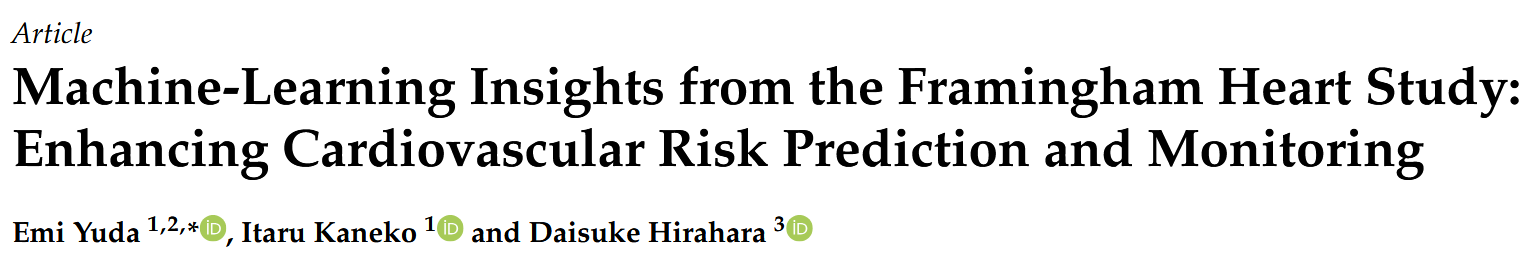

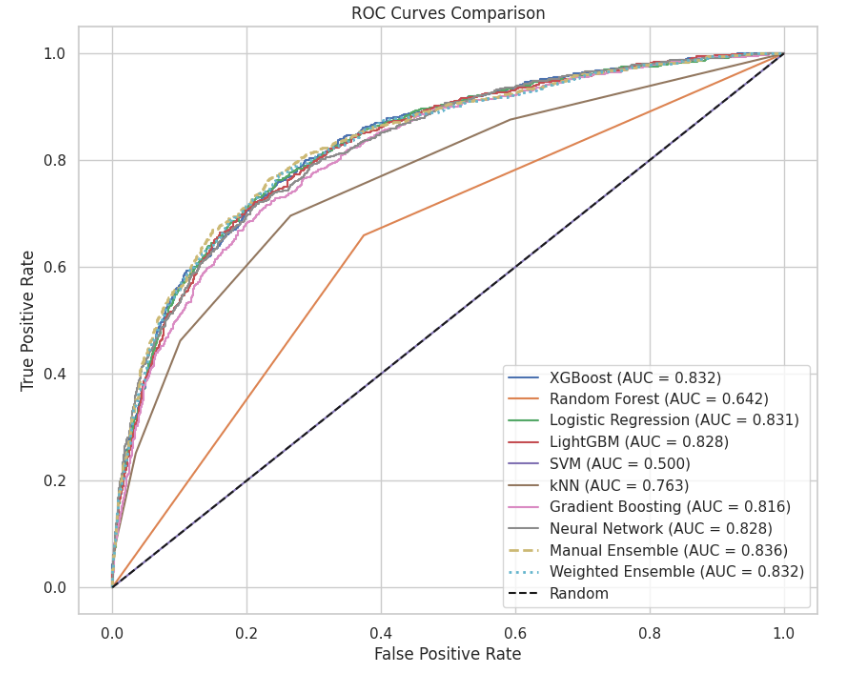

XGBOOST INTERACTIVE

Explorez l'impact du nombre d'itérations et du taux d'apprentissage
Conseil : learning_rate faible nécessite plus d'itérations



interactive(children=(IntSlider(value=100, description='Nb itérations :', max=300, min=10, step=10, style=Slid…

---

# Étape 6 : Neural Networks - Apprentissage Profond

## Principe

Les **réseaux de neurones artificiels** s'inspirent du fonctionnement du cerveau :
- Neurones organisés en **couches** (input → hidden layers → output)
- Chaque neurone calcule une combinaison pondérée de ses entrées
- Fonction d'activation non-linéaire (ReLU, sigmoid)
- Apprentissage par **rétropropagation** du gradient


## Objectif de cette étape

Démontrer honnêtement que les Neural Networks ne sont pas meilleurs ici, et comprendre pourquoi. C'est une leçon importante : **le bon algorithme dépend du contexte.**

In [ ]:
# Widget interactif : Neural Network

def neural_network_interactive(hidden_layer_size=20, learning_rate_init=0.001):
    """Neural Network simple (2 couches cachées)"""
    
    # Préparation données
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Standardisation (essentielle pour NN)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Modèle Neural Network (MLPClassifier)
    model_nn = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_size, hidden_layer_size // 2),
        learning_rate_init=learning_rate_init,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )
    
    model_nn.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred_proba = model_nn.predict_proba(X_test_scaled)[:, 1]
    y_pred = model_nn.predict(X_test_scaled)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features_scaled = scaler.transform(
        patient_data[feature_cols_all].values.reshape(1, -1)
    )
    patient_risk_nn = model_nn.predict_proba(patient_features_scaled)[0, 1] * 100
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Courbe de perte (loss)
    ax1 = axes[0]
    
    loss_curve = model_nn.loss_curve_
    ax1.plot(loss_curve, color='purple', lw=2.5)
    ax1.set_xlabel('Itérations')
    ax1.set_ylabel('Loss (Log-Loss)')
    ax1.set_title('Courbe d\'Apprentissage - Neural Network', fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Annotation convergence
    if len(loss_curve) < 500:
        ax1.annotate('Early stopping', 
                    xy=(len(loss_curve), loss_curve[-1]),
                    xytext=(len(loss_curve)*0.7, loss_curve[-1]*1.2),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, color='red')
    
    # Graphique 2 : Comparaison ROC
    ax2 = axes[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='purple', lw=2.5, 
            label=f'Neural Network (AUC = {auc:.3f})')
    
    # Comparaison avec autres méthodes
    if 'results_lr' in globals():
        ax2.plot([], [], ' ', label=f'Rég. Log. (AUC = {results_lr["auc"]:.3f})', color='orange')
    if 'results_rf' in globals():
        ax2.plot([], [], ' ', label=f'Random Forest (AUC = {results_rf["auc"]:.3f})', color='blue')
    if 'results_gb' in globals():
        ax2.plot([], [], ' ', label=f'XGBoost (AUC = {results_gb["auc"]:.3f})', color='green')
    
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    ax2.set_xlabel('Taux de Faux Positifs')
    ax2.set_ylabel('Taux de Vrais Positifs')
    ax2.set_title('Courbe ROC - Comparaison des Méthodes', fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print("\n" + "="*70)
    print("NEURAL NETWORK - RÉSULTATS")
    print("="*70)
    
    print(f"\nARCHITECTURE :")
    print(f"  Couche d'entrée     : 10 neurones (10 variables)")
    print(f"  Couche cachée 1     : {hidden_layer_size} neurones")
    print(f"  Couche cachée 2     : {hidden_layer_size // 2} neurones")
    print(f"  Couche de sortie    : 1 neurone (probabilité)")
    print(f"  Fonction activation : ReLU")
    print(f"  Learning rate       : {learning_rate_init:.4f}")
    print(f"  Itérations          : {len(loss_curve)}")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    # Comparaison avec toutes les méthodes
    print(f"\nCOMPARAISON AVEC AUTRES MÉTHODES :")
    methods_comparison = []
    
    if 'results_lr' in globals():
        methods_comparison.append(('Régression Logistique', results_lr['auc']))
    if 'results_rf' in globals():
        methods_comparison.append(('Random Forest', results_rf['auc']))
    if 'results_gb' in globals():
        methods_comparison.append(('XGBoost', results_gb['auc']))
    methods_comparison.append(('Neural Network', auc))
    
    methods_comparison.sort(key=lambda x: x[1], reverse=True)
    
    for i, (method, score) in enumerate(methods_comparison):
        marker = " ← MEILLEUR" if i == 0 else ""
        print(f"  {i+1}. {method:25s}: AUC = {score:.3f}{marker}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Neural Net: {patient_risk_nn:.1f}%")
    if 'results_gb' in globals():
        print(f"  XGBoost   : {results_gb['patient_risk']:.1f}%")
    if 'results_rf' in globals():
        print(f"  Rand. For.: {results_rf['patient_risk']:.1f}%")
    
    print(f"\nCONCLUSION IMPORTANTE :")
    print(f"  Sur un dataset de {len(df_clean)} patients, le Neural Network")
    print(f"  n'est PAS meilleur que XGBoost ou Random Forest.")
    print(f"  ")
    print(f"  Raisons :")
    print(f"  1. Trop peu de données pour entraîner efficacement les paramètres")
    print(f"  2. XGBoost/RF plus adaptés aux données tabulaires de petite taille")
    print(f"  3. Les NN brillent avec des millions d'exemples (images, texte)")
    print(f"  ")
    print(f"  Leçon : Le meilleur algorithme dépend du CONTEXTE (type et volume de données).")
    
    # Sauvegarde
    global results_nn
    results_nn = {
        'method': 'Neural Network',
        'hidden_layers': (hidden_layer_size, hidden_layer_size // 2),
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_nn
    }

# Interface
print("="*70)
print("NEURAL NETWORK INTERACTIVE")
print("="*70)
print("\nExplorez l'architecture du réseau de neurones")
print("Observation : Les performances ne dépasseront pas XGBoost/RF\n")

interact(neural_network_interactive,
         hidden_layer_size=IntSlider(
             min=5, max=50, step=5, value=20,
             description='Neurones (L1) :',
             style={'description_width': 'initial'}
         ),
         learning_rate_init=FloatSlider(
             min=0.0001, max=0.01, step=0.0001, value=0.001,
             description='Learning rate :',
             style={'description_width': 'initial'},
             readout_format='.4f'
         ));

NEURAL NETWORK INTERACTIVE

Explorez l'architecture du réseau de neurones
Observation : Les performances ne dépasseront pas XGBoost/RF



interactive(children=(IntSlider(value=20, description='Neurones (L1) :', max=50, min=5, step=5, style=SliderSt…

## Avantages

1. **Représentations complexes** : Apprend des features de haut niveau
2. **Flexibilité** : Architecture adaptable au problème
3. **Performances** : Excellentes sur images, texte, signaux
4. **Multimodalité** : Combine différents types de données

## Limites (sur petits datasets comme Framingham)

1. **Besoin de données massives** : Millions d'exemples pour exceller
2. **Sur-apprentissage** : Très facile avec <10,000 patients
3. **Temps d'entraînement** : Beaucoup plus long
4. **Interprétabilité** : Boîte noire totale
5. **Hyperparamètres** : Difficile à régler

## Vérité importante

Pourquoi ?
- Trop peu de données pour entraîner efficacement les nombreux paramètres
- XGBoost/Random Forest sont plus efficaces sur données tabulaires de petite taille
- Les NN brillent avec : images (millions), texte (milliards), signaux physiologiques

## Quand utiliser les Neural Networks en santé ?

**Cas favorables** :
- Imagerie médicale (millions d'images)
- Signaux physiologiques (ECG, EEG)
- Données textuelles (dossiers médicaux)
- Données multimodales (image + bio + texte)
- Très gros datasets (MIMIC-IV : 50,000+ patients)

**Cas défavorables** :
- Données tabulaires <10,000 patients
- Besoin d'interprétabilité forte
- Ressources de calcul limitées

# Le phénotypage : l'alliance entre IA et méthodologie statistique

---

## Étape 1 : Clustering K-means - Identification des Phénotypes

**K-means** est un algorithme de clustering qui :
1. Choisit K centres initiaux (centroids) aléatoirement
2. Assigne chaque patient au centre le plus proche
3. Recalcule les centres comme moyenne des patients assignés
4. Répète 2-3 jusqu'à convergence

#### Distance euclidienne

Les patients sont regroupés selon leur **proximité** dans l'espace des variables :

$$d(x_i, x_j) = \sqrt{\sum_{k=1}^p (x_{ik} - x_{jk})^2}$$

#### Choix du nombre de clusters (K)

Plusieurs critères :
- **Méthode du coude** : Inertie en fonction de K
- **Silhouette score** : Qualité des clusters (entre -1 et 1)
- **Interprétabilité clinique** : Les phénotypes ont-ils un sens ?

#### Variables utilisées pour le clustering

Nous sélectionnerons les **variables cliniques continues** :
- Âge
- PA systolique
- Cholestérol total
- IMC
- Glycémie

**Note** : Les variables catégorielles (sexe, tabac, diabète) seront analysées post-hoc pour caractériser les phénotypes.
